<a href="https://colab.research.google.com/github/Maher1410/Q-Learning-in-a-Hybrid-Approach/blob/main/Implementing_Q_Learning_in_a_Hybrid_Approach(Final).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Episode 0: Total Reward = -128
Episode 100: Total Reward = 93
Converged at episode 196


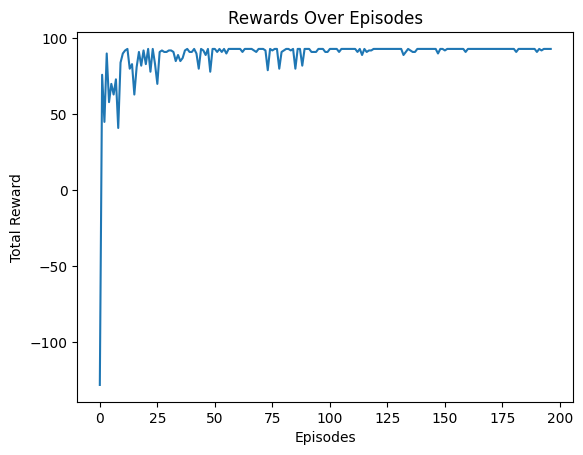

Optimal Policy:
r d r d d
d d r r d
r d X r d
r r d X d
r r r r G



In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

# ------------------------- Gridworld Environment -------------------------
class Gridworld:
    def __init__(self, grid_size=5, start=(0, 0), goal=(4, 4), obstacles=None):
        self.grid_size = grid_size
        self.start = start
        self.goal = goal
        self.obstacles = obstacles or [(2, 2), (3, 3)]  # Default obstacles
        self.action_space = ['up', 'down', 'left', 'right']
        self.reset()
        self.reward_map = self._initialize_rewards()

    def _initialize_rewards(self):
        """Initialize the reward grid with penalties, obstacles, and goal reward."""
        rewards = np.full((self.grid_size, self.grid_size), -1)  # Step penalty
        rewards[self.goal] = 100  # Goal reward
        for obstacle in self.obstacles:
            rewards[obstacle] = -10  # Obstacle penalty
        return rewards

    def reset(self):
        """Reset the environment to the start position."""
        self.state = self.start
        return self.state

    def step(self, action):
        """Perform an action and return the next state, reward, and done flag."""
        row, col = self.state
        moves = {'up': (-1, 0), 'down': (1, 0), 'left': (0, -1), 'right': (0, 1)}
        delta_row, delta_col = moves[action]

        # Update state and enforce grid boundaries
        row = max(0, min(self.grid_size - 1, row + delta_row))
        col = max(0, min(self.grid_size - 1, col + delta_col))

        self.state = (row, col)
        reward = self.reward_map[row, col]
        done = self.state == self.goal

        return self.state, reward, done

    def render(self, policy=None, path=None):
        """Render the gridworld, showing obstacles, goal, policy, or agent path."""
        grid = np.full((self.grid_size, self.grid_size), '.')
        grid[self.goal] = 'G'
        for obs in self.obstacles:
            grid[obs] = 'X'

        if path:
            for r, c in path:
                grid[r, c] = 'A'

        if policy:
            for r in range(self.grid_size):
                for c in range(self.grid_size):
                    if grid[r, c] == '.':
                        grid[r, c] = policy.get((r, c), '.')

        print('\n'.join(' '.join(row) for row in grid))
        print()


# ------------------------- Q-Learning Algorithm -------------------------
def q_learning(env, episodes=1000, alpha=0.1, gamma=0.9, epsilon=0.1, decay=0.995, convergence_thresh=0.01):
    """Q-Learning implementation for training the agent."""
    q_table = np.zeros((env.grid_size, env.grid_size, len(env.action_space)))
    rewards_per_episode = []
    previous_q = np.copy(q_table)

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            row, col = state
            # Epsilon-greedy action selection
            if random.uniform(0, 1) < epsilon:
                action = random.choice(env.action_space)
            else:
                action = env.action_space[np.argmax(q_table[row, col])]

            # Perform action and update Q-table
            next_state, reward, done = env.step(action)
            total_reward += reward

            next_row, next_col = next_state
            action_idx = env.action_space.index(action)
            q_table[row, col, action_idx] = q_table[row, col, action_idx] + alpha * (
                reward + gamma * np.max(q_table[next_row, next_col]) - q_table[row, col, action_idx]
            )
            state = next_state

        rewards_per_episode.append(total_reward)

        # Convergence check
        if np.max(np.abs(q_table - previous_q)) < convergence_thresh:
            print(f"Converged at episode {episode}")
            break
        previous_q = np.copy(q_table)

        # Decay epsilon
        epsilon = max(epsilon * decay, 0.01)

        if episode % 100 == 0:
            print(f"Episode {episode}: Total Reward = {total_reward}")

    # Extract the policy from Q-table
    policy = {(r, c): env.action_space[np.argmax(q_table[r, c])]
              for r in range(env.grid_size) for c in range(env.grid_size)}
    return q_table, rewards_per_episode, policy


# ------------------------- Utility Functions -------------------------
def plot_rewards(rewards, title="Rewards Over Episodes"):
    """Plot the rewards collected per episode."""
    plt.plot(rewards)
    plt.title(title)
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.show()


# ------------------------- Main Execution -------------------------
if __name__ == "__main__":
    # Initialize environment
    env = Gridworld(grid_size=5, start=(0, 0), goal=(4, 4), obstacles=[(2, 2), (3, 3)])

    # Train using Q-learning
    q_table, rewards, optimal_policy = q_learning(
        env, episodes=1000, alpha=0.1, gamma=0.9, epsilon=0.1, decay=0.995
    )

    # Plot the reward progression
    plot_rewards(rewards)

    # Display the optimal policy
    print("Optimal Policy:")
    env.render(policy=optimal_policy)


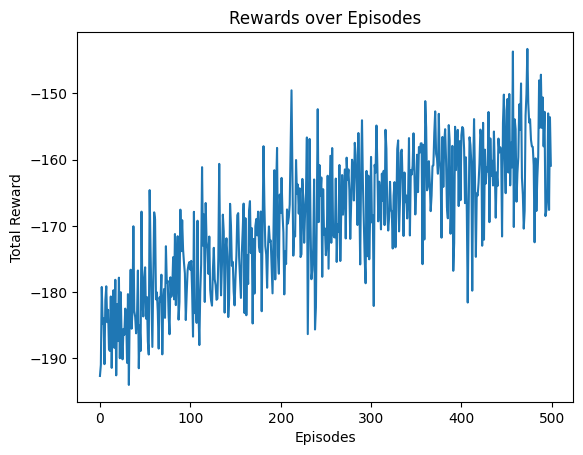

/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Final test reward: -200.0
Video recorded in: ./video


In [4]:
import gym
from gym.wrappers.record_video import RecordVideo
import numpy as np
import os
import matplotlib.pyplot as plt

video_path = "./video"
os.makedirs(video_path, exist_ok=True)

env = gym.make('MountainCar-v0', render_mode='rgb_array')

def discretize_state(state, state_bins, state_bounds):
    ratios = [(state[i] - state_bounds[i][0]) / (state_bounds[i][1] - state_bounds[i][0])
              for i in range(len(state))]
    new_state = [int(np.round((bins - 1) * ratio)) for ratio, bins in zip(ratios, state_bins)]
    new_state = [min(bins - 1, max(0, s)) for s, bins in zip(new_state, state_bins)]
    return tuple(new_state)

def choose_action(state, epsilon, q_table, action_space):
    if np.random.random() < epsilon:
        return np.random.randint(0, action_space)
    return np.argmax(q_table[state])

def train_mountain_car(env, q_table, state_bins, state_bounds, episodes=500, alpha=0.1, gamma=0.995, epsilon=1.0, epsilon_decay=0.998):
    rewards = []
    for episode in range(episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]
        discretized_state = discretize_state(state, [state_bins]*len(state), state_bounds)
        total_reward = 0
        done = False
        while not done:
            action = choose_action(discretized_state, epsilon, q_table, env.action_space.n)
            result = env.step(action)
            if len(result) == 4:
                next_state, reward, done, _ = result
            elif len(result) == 5:
                next_state, reward, done, _, _ = result

            reward += abs(next_state[0] - (-0.5))
            discretized_next_state = discretize_state(next_state, [state_bins]*len(next_state), state_bounds)

            q_table[discretized_state+(action,)] = (1 - alpha)*q_table[discretized_state+(action,)] + \
                                                    alpha*(reward + gamma*np.max(q_table[discretized_next_state]))

            discretized_state = discretized_next_state
            total_reward += reward

        rewards.append(total_reward)
        epsilon = max(epsilon * epsilon_decay, 0.01)
    return q_table, rewards

def test_agent(env, q_table, state_bins, state_bounds):
    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]
    total_reward = 0
    done = False
    while not done:
        discretized_state = discretize_state(state, [state_bins]*len(state), state_bounds)
        action = np.argmax(q_table[discretized_state])
        result = env.step(action)
        if len(result) == 4:
            state, reward, done, _ = result
        elif len(result) == 5:
            state, reward, done, _, _ = result
        total_reward += reward
    return total_reward

state_bins = 40
state_bounds = list(zip(env.observation_space.low, env.observation_space.high))
state_space = len(env.observation_space.low)
q_table = np.zeros([state_bins]*state_space+[env.action_space.n])

q_table, rewards = train_mountain_car(env, q_table, state_bins, state_bounds, episodes=500)

plt.plot(rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Rewards over Episodes')
plt.show()

# Create a new environment with video recording for the final test
test_env = gym.make('MountainCar-v0', render_mode='rgb_array')  # Removed new_step_api
test_env = RecordVideo(test_env, video_path, episode_trigger=lambda episode_id: True)
final_reward = test_agent(test_env, q_table, state_bins, state_bounds)
print("Final test reward:", final_reward)
test_env.close()
print("Video recorded in:", video_path)
